In [1]:
import os
import cv2 as cv
#
#tomes = os.listdir("./train/")
#for tome in tomes:
#    imgs = os .listdir(f"./train/{tome}/pages/")
#    os.makedirs(f"./train/{tome}/pages_BW")
#    for img in imgs:
#        try:
#            image = cv.imread(f'./train/{tome}/pages/{img}')
#            SE = cv.getStructuringElement(cv.MORPH_ELLIPSE, (7,7))
#            background = cv.morphologyEx(image, cv.MORPH_DILATE, SE)
#            image = cv.divide(image, background, scale=255)
#            image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
#            cv.imwrite(f"./train/{tome}/pages_BW/{img}", image)
#        except: pass

In [2]:
#tomes = os.listdir("./train/")
#
#with open("./images.csv", "w", newline='') as csvfile:
#    for tome in tomes:
#        imgs = os.listdir(f"./train/{tome}/pages_BW/")
#        for img in imgs:
#            csvfile.writelines(f"./train/{tome}/pages_BW/{img};./train/{tome}/pages/{img}\n")
#

In [51]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.io import read_image, ImageReadMode
from torchinfo import summary
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F

from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt



In [88]:
BATCH_SIZE = 8
IMG_SHAPE = (256, 256)

#On crée un dataset custom à partir des images du dossier 'dataset'
class TrainDataset(Dataset):
    def __init__(self, img_csv, img_size):
        self.img_csv = pd.read_csv(img_csv, delimiter=";")
        self.transform = transforms.Resize(img_size)

    def __len__(self):
        return len(self.img_csv)

    def __getitem__(self, index):
        img_paths = self.img_csv.iloc[index, :]
        image = [read_image(img_paths[0]), read_image(img_paths[1], ImageReadMode.RGB)]
        # On reshape les données :

        image = [self.transform(img) for img in image]

        #On normalise les données
        image = [(img - 127.5)/127.5 for img in image]
        return image[0], image[1]


training_data = TrainDataset('./images.csv', IMG_SHAPE)

#On charge notre dataset dans un dataloader
x_train = DataLoader(training_data, batch_size = BATCH_SIZE, shuffle = True)

C:\Users\pferi\AppData\Local\Temp\ipykernel_7780\237808255.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = [read_image(img_paths[0]), read_image(img_paths[1], ImageReadMode.RGB)]
d:\Documents\Coding\IA\Colorisation\.venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inf

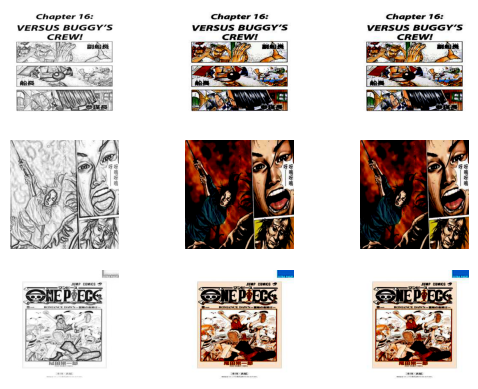

In [89]:

for i,(img, gray_img) in enumerate(x_train):
    plt.subplot(3, 3, 3*i+1)
    plt.imshow(img[0].permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.subplot(3, 3, 3*i + 2)
    plt.imshow(gray_img[0].permute(1,2,0))
    plt.axis('off')
    plt.subplot(3, 3, 3*i + 3)
    plt.imshow(gray_img[0].permute(1,2,0))
    plt.axis('off')
    if i >= 2:
        break
    

In [90]:
class Identity(nn.Module):
    def __init__(self, channel):
        super().__init__()
        self.conv1 = nn.Conv2d(channel, channel, 3, 1, padding='same')
        self.batch1 = nn.BatchNorm2d(channel)
        self.conv2 = nn.Conv2d(channel, channel, 4, 1, padding='same')
        self.batch2 = nn.BatchNorm2d(channel)
        self.conv3 = nn.Conv2d(channel, channel, 5, 1, padding='same')
        self.batch3 = nn.BatchNorm2d(channel)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.batch3(x)
        x = self.relu(x)
        return x


class down_scale(nn.Module):
    def __init__(self, channel_in, channel_out):
        super().__init__()
        self.down1 = nn.Conv2d(channel_in, channel_out, 3, stride=2, padding=1)
        self.down2 = nn.Conv2d(channel_in, channel_out, 5, stride=2, padding=2)
        self.batch_down1 = nn.BatchNorm2d(channel_out)
        self.batch_down2 = nn.BatchNorm2d(channel_out)
        self.id1 = nn.Conv2d(channel_in, channel_in, 3, stride=1, padding='same')
        self.batch_id1 = nn.BatchNorm2d(channel_in)
        self.id2 = nn.Conv2d(channel_out, channel_out, 5, stride=1, padding='same')
        self.batch_id2 = nn.BatchNorm2d(channel_out)
        self.identity = Identity(channel_out)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x1 = x
        x = self.id1(x)
        x = self.batch_id1(x)
        x = self.relu(x)
        x = self.down1(x)
        x = self.batch_down1(x)
        x = self.relu(x)
        x = self.id2(x)
        x = self.batch_id2(x)
        x = self.relu(x)
        x1 = self.down2(x1)
        x1 = self.batch_down2(x1)
        x1 = self.relu(x1)
        x = self.identity(x + x1)
        return x
        

down = down_scale(32, 64)
print(summary(down, (BATCH_SIZE, 32, 256, 256)))
    
    


Layer (type:depth-idx)                   Output Shape              Param #
down_scale                               [8, 64, 128, 128]         --
├─Conv2d: 1-1                            [8, 32, 256, 256]         9,248
├─BatchNorm2d: 1-2                       [8, 32, 256, 256]         64
├─ReLU: 1-3                              [8, 32, 256, 256]         --
├─Conv2d: 1-4                            [8, 64, 128, 128]         18,496
├─BatchNorm2d: 1-5                       [8, 64, 128, 128]         128
├─ReLU: 1-6                              [8, 64, 128, 128]         --
├─Conv2d: 1-7                            [8, 64, 128, 128]         102,464
├─BatchNorm2d: 1-8                       [8, 64, 128, 128]         128
├─ReLU: 1-9                              [8, 64, 128, 128]         --
├─Conv2d: 1-10                           [8, 64, 128, 128]         51,264
├─BatchNorm2d: 1-11                      [8, 64, 128, 128]         128
├─ReLU: 1-12                             [8, 64, 128, 128]        

In [91]:

class up_scale(nn.Module):
    def __init__(self, channel_in, channel_out):
        super().__init__()
        self.up1 = nn.ConvTranspose2d(channel_in, channel_out, 3, stride=2, padding=1, output_padding=1)
        self.up2 = nn.ConvTranspose2d(channel_in, channel_out, 5, stride=2, padding=2, output_padding=1)
        self.batch_up1 = nn.BatchNorm2d(channel_out)
        self.batch_up2 = nn.BatchNorm2d(channel_out)
        self.id1 = nn.Conv2d(channel_in, channel_in, 3, stride=1, padding='same')
        self.batch_id1 = nn.BatchNorm2d(channel_in)
        self.id2 = nn.Conv2d(channel_out, channel_out, 5, stride=1, padding='same')
        self.batch_id2 = nn.BatchNorm2d(channel_out)
        self.identity = Identity(channel_out)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x1 = x
        x = self.id1(x)
        x = self.batch_id1(x)
        x = self.relu(x)
        x = self.up1(x)
        x = self.batch_up1(x)
        x = self.relu(x)
        x = self.id2(x)
        x = self.batch_id2(x)
        x = self.relu(x)
        x1 = self.up2(x1)
        x1 = self.batch_up2(x1)
        x1 = self.relu(x1)
        x = self.identity(x + x1)
        return x
        

up = up_scale(64, 32)
print(summary(up, (BATCH_SIZE, 64, 64, 64)))

Layer (type:depth-idx)                   Output Shape              Param #
up_scale                                 [8, 32, 128, 128]         --
├─Conv2d: 1-1                            [8, 64, 64, 64]           36,928
├─BatchNorm2d: 1-2                       [8, 64, 64, 64]           128
├─ReLU: 1-3                              [8, 64, 64, 64]           --
├─ConvTranspose2d: 1-4                   [8, 32, 128, 128]         18,464
├─BatchNorm2d: 1-5                       [8, 32, 128, 128]         64
├─ReLU: 1-6                              [8, 32, 128, 128]         --
├─Conv2d: 1-7                            [8, 32, 128, 128]         25,632
├─BatchNorm2d: 1-8                       [8, 32, 128, 128]         64
├─ReLU: 1-9                              [8, 32, 128, 128]         --
├─ConvTranspose2d: 1-10                  [8, 32, 128, 128]         51,232
├─BatchNorm2d: 1-11                      [8, 32, 128, 128]         64
├─ReLU: 1-12                             [8, 32, 128, 128]         -

In [92]:
class AutoEncoder(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.down1 = down_scale(1, n)
        self.down2 = down_scale(n, n*2)
        self.down3 = down_scale(n*2, n*4)
        self.down4 = down_scale(n*4, n*8)
        self.down5 = down_scale(n*8, n*16)
        self.up1 = up_scale(n*16, n*8)
        self.up2 = up_scale(n*8, n*4)
        self.up3 = up_scale(n*4, n*2)
        self.up4 = up_scale(n*2, n)
        self.up5 = up_scale(n, 1)
        self.relu = nn.ReLU()
        
    
    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        x = self.up1(x5)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)
        x = self.up5(x)
        return x
    

model = AutoEncoder(16)
print(summary(model, (BATCH_SIZE, 1, 64, 64)))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [8, 1, 64, 64]            --
├─down_scale: 1-1                        [8, 16, 32, 32]           --
│    └─Conv2d: 2-1                       [8, 1, 64, 64]            10
│    └─BatchNorm2d: 2-2                  [8, 1, 64, 64]            2
│    └─ReLU: 2-3                         [8, 1, 64, 64]            --
│    └─Conv2d: 2-4                       [8, 16, 32, 32]           160
│    └─BatchNorm2d: 2-5                  [8, 16, 32, 32]           32
│    └─ReLU: 2-6                         [8, 16, 32, 32]           --
│    └─Conv2d: 2-7                       [8, 16, 32, 32]           6,416
│    └─BatchNorm2d: 2-8                  [8, 16, 32, 32]           32
│    └─ReLU: 2-9                         [8, 16, 32, 32]           --
│    └─Conv2d: 2-10                      [8, 16, 32, 32]           416
│    └─BatchNorm2d: 2-11                 [8, 16, 32, 32]           32
│    └─ReLU

In [93]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

0it [00:00, ?it/s]C:\Users\pferi\AppData\Local\Temp\ipykernel_7780\237808255.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = [read_image(img_paths[0]), read_image(img_paths[1], ImageReadMode.RGB)]
d:\Documents\Coding\IA\Colorisation\.venv\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8, 3, 256, 256])) that is different to the input size (torch.Size([8, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss : 71.85501098632812


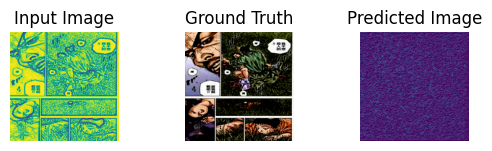

6it [00:18,  3.01s/it]


KeyboardInterrupt: 

In [94]:
epoch = 10
for i in range(epoch):
    for j, batch in tqdm(enumerate(x_train)):
        
        optimizer.zero_grad()
        x, y = batch
        y_hat = model(x)
        loss = loss_function(y_hat, y)*100
        loss.backward()
        optimizer.step()
        if j % 10 == 0:
            print(f"Loss : {loss.item()}")
            plt.subplot(3, 3, 1)
            plt.imshow(x[0].permute(1, 2, 0).detach().numpy())
            plt.title('Input Image')
            plt.axis('off')
            plt.subplot(3, 3, 2)
            plt.imshow(y[0].permute(1,2,0).detach().numpy())
            plt.title('Ground Truth')
            plt.axis('off')
            plt.subplot(3, 3, 3)
            plt.imshow(y_hat[0].permute(1,2,0).detach().numpy())
            plt.title('Predicted Image')
            plt.axis('off')
            plt.show()
    print(f"Epoch {i+1}/{epoch} terminée, Loss : {loss.item()}")
